# Training a CNN + FNO on the Shallow Water equations on 2D plane


### Initialize

In [33]:
save_plots = 0
save_results = 0
n_epochs_CNN = 10
n_epochs_FNO = 10

Nx = 50
tend = 5

### Load packages

In [34]:
import time
import sys
import h5py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR
import torch.nn.functional as F

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.models import SFNO
from neuralop import LpLoss, H1Loss

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange

#from tabulate import tabulate
import time

from utils import *
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Functions

In [35]:
def prepare_data_2D(h_all, p_train, p_val):
    h_all = np.real(h_all)

    # Input a
    a = h_all[:-1]

    # Target u (one time step after a)
    u = h_all[1:]
    n = len(h_all)

    # Split data into training, validation and test sets
    n_train = int(p_train * n)
    n_val = int(p_val * n)
    n_test = n - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    train_x = torch.tensor(a[:n_train], dtype=torch.float32)  # Shape (n_train, 3, 256)
    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, 3, 256)
    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, 3, 256)

    train_y = torch.tensor(u[:n_train], dtype=torch.float32)  # Shape (n_train, ...)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, ...)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, ...)

    print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y


### Plot initial condition

In [36]:
# Construct the file path 
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO/toro2D_N={Nx}_t={tend}.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        print(key)
    
    Q_all = f['Q_all'][:]
    t_all = f['t_all'][:]
    x = f['x'][:]
    y = f['y'][:]

print(f'Loaded Q_all with shape {Q_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded x with shape {x.shape}')
print(f'Loaded y with shape {y.shape}')

h_all = Q_all[:, 0, :, :]

## Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_2D(h_all, p_train, p_val)

Q_all
t_all
x
y
Loaded Q_all with shape (63, 3, 50, 50)
Loaded t_all with shape (63,)
Loaded x with shape (50,)
Loaded y with shape (50,)
n_train = 37, n_val = 12, n_test = 14
torch.Size([37, 50, 50]) torch.Size([37, 50, 50]) torch.Size([12, 50, 50]) torch.Size([12, 50, 50]) torch.Size([13, 50, 50]) torch.Size([13, 50, 50])


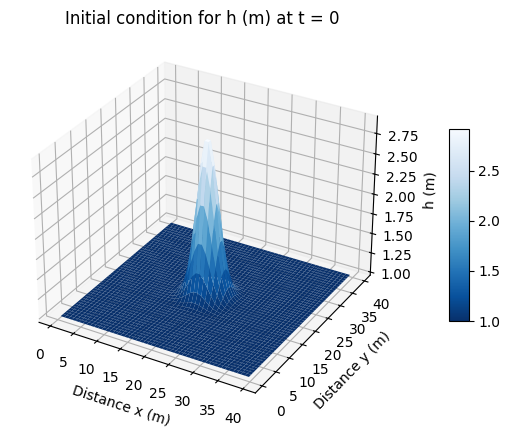

In [37]:
cmap = 'Blues_r'
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, h_all[0], cmap = cmap)
ax.set_title('Initial condition for h (m) at t = 0')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
ax.set_zlabel('h (m)')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

if 0:
    plt.savefig('plots/2D_gauss_initial_condition.pdf', format='pdf')

plt.show()

## CNN

### Load data from h5 file

In [38]:
# Construct the file path 
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO/toro2D_N={Nx}_t={tend}.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        print(key)
    
    Q_all = f['Q_all'][:]
    t_all = f['t_all'][:]
    x = f['x'][:]
    y = f['y'][:]

print(f'Loaded Q_all with shape {Q_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded x with shape {x.shape}')
print(f'Loaded y with shape {y.shape}')

h_all = Q_all[:, 0, :, :]

## Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_2D(h_all, p_train, p_val)

Q_all
t_all
x
y
Loaded Q_all with shape (63, 3, 50, 50)
Loaded t_all with shape (63,)
Loaded x with shape (50,)
Loaded y with shape (50,)
n_train = 37, n_val = 12, n_test = 14
torch.Size([37, 50, 50]) torch.Size([37, 50, 50]) torch.Size([12, 50, 50]) torch.Size([12, 50, 50]) torch.Size([13, 50, 50]) torch.Size([13, 50, 50])


In [39]:
# Define CNN-based model
class CNNFlowmap(nn.Module):
    def __init__(self, input_channels, spatial_steps, output_size, num_filters=64, kernel_size=3, num_layers=4):
        super(CNNFlowmap, self).__init__()
        self.conv = nn.Conv2d(input_channels, num_filters, kernel_size, padding=1)
        #self.conv2 = nn.Conv2d(batch_size, batch_size, kernel_size = 1)
        self.final_conv = nn.Conv2d(num_filters, 1, kernel_size=1)  # kernel_size=1 preserves spatial size

    def forward(self, x):
        # Input shape: [batch_size, seq_length, spatial_steps]
        x = x
        x = self.conv(x)       # Apply convolutional layers
        x = F.relu(x)          # Apply ReLU activation
        x = self.final_conv(x)
        x = x.squeeze(1)       # Remove channel dimension
        #x = self.conv2(x)
        #x = self.fc(x)         # Apply fully connected layers
        return x
    
input_channels = 10 # seq_length
output_channels = 1
spatial_steps = Nx
output_size = 50
batch_size = 16

# Instantiate the CNN model
model = CNNFlowmap(input_channels, spatial_steps, output_size)
print(model)

# Example forward pass
batch_x = torch.randn(n_train-10, input_channels, spatial_steps, spatial_steps)
print("Input shape:", batch_x.shape)
output = model(batch_x)
print("Output shape:", output.shape)

CNNFlowmap(
  (conv): Conv2d(10, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (final_conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)
Input shape: torch.Size([27, 10, 50, 50])
Output shape: torch.Size([27, 50, 50])


In [40]:
# Prepare data in sequences
seq_length = 10

X_input_train, X_output_train = prepare_data_sequences_2D(train_x, train_y, seq_length)
print(X_input_train.shape, X_output_train.shape)

X_input_val, X_output_val = prepare_data_sequences_2D(val_x, val_y, seq_length)
X_input_test, X_output_test = prepare_data_sequences_2D(test_x, test_y, seq_length)

batch_size = 32

# Create a dataloader for training and validation data
train_dataset = torch.utils.data.TensorDataset(X_input_train, X_output_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_input_val, X_output_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

# Loss function
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_train = []
loss_val = []

# Time training
start = time.time()

# Training loop
n_epochs = n_epochs_CNN
for epoch in range(n_epochs):
    model.train() # Set model to training mode
    epoch_train_loss = 0

    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0) # Accumulate loss

    # Validation loss
    model.eval() # Set model to evaluation mode
    epoch_val_loss = 0
    with torch.no_grad(): # Disable gradient tracking
        for val_X, val_y in val_loader:
            val_predictions = model(val_X)
            val_loss = loss_fn(val_predictions, val_y)
            epoch_val_loss += val_loss.item() * val_X.size(0)
    
    # Average loss
    epoch_train_loss /= len(train_loader.dataset)
    epoch_val_loss /= len(val_loader.dataset)

    # Save losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print losses
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}: Train loss = {epoch_train_loss:.6f}, Val loss = {epoch_val_loss:.6f}")

# Time training
end = time.time()
training_time = end - start
print(f"Training time: {training_time:.2f}s")

torch.Size([27, 10, 50, 50]) torch.Size([27, 50, 50])
Epoch 0/10: Train loss = 0.883724, Val loss = 0.547789
Training time: 0.53s


In [41]:
# Save the training time
# Specify folder path (create the folder if it doesn't exist)
folder_path = 'C:/Users/Matteo/Shallow-Water-Equations/saved_results'
os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist

# Save the training time
if save_results:
    file_path = os.path.join(folder_path, f'2D_CNN_Nx={Nx}_time.txt')
    with open(file_path, 'w') as f:
        f.write(f"{training_time:.2f}") # Save with 2 decimals

    # Save n_epochs
    file_path = os.path.join(folder_path, f'2D_CNN_Nx={Nx}_nepochs.txt')
    with open(file_path, 'w') as f:
        f.write(f"{n_epochs_CNN}") 

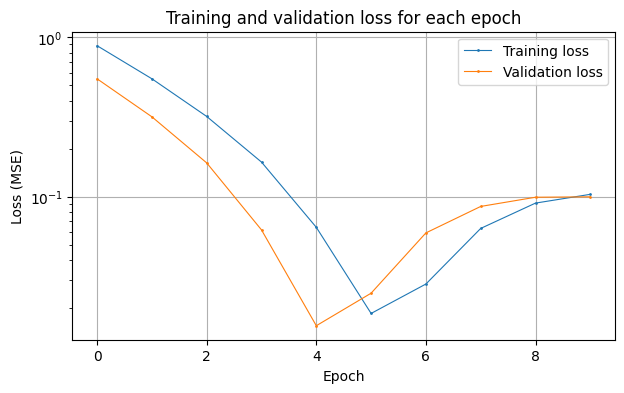

In [42]:
filename = 'plots/2D_CNN_loss.pdf'
plot_losses(loss_train, loss_val, save_plots, filename)

### Make predictions

In [43]:
# Make predictions
model.eval()
with torch.no_grad():
    pred_train = model(X_input_train).cpu().detach().numpy()
    pred_val = model(X_input_val).cpu().detach().numpy()
    pred_test = model(X_input_test).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_val, pred_test], axis=0)
print(pred_all.shape)

# Compute loss
train_loss = loss_fn(torch.tensor(pred_train), X_output_train).item()
val_loss = loss_fn(torch.tensor(pred_val), X_output_val).item()
test_loss = loss_fn(torch.tensor(pred_test), X_output_test).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

X_all, Y_all = prepare_data_sequences_2D(torch.tensor(a, dtype=torch.float32), torch.tensor(u, dtype=torch.float32), seq_length)

# Make predictions
model.eval()    # Set model to evaluation mode
with torch.no_grad():
    pred_all = model(X_all).cpu().detach().numpy()
    overall_loss = loss_fn(torch.tensor(pred_all), Y_all).item()
    print(f"Overall loss: {overall_loss:.2e}")

# Save the test loss MSE
if save_results:
    file_path = os.path.join(folder_path, f'2D_CNN_Nx={Nx}_MSE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

(32, 50, 50)
Train loss: 1.04e-01
Validation loss: 9.97e-02
Test loss: 1.02e-01
Overall loss: 1.03e-01


In [44]:
# Calculate MAE
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train), X_output_train).item()
val_loss = loss_new(torch.tensor(pred_val), X_output_val).item()
test_loss = loss_new(torch.tensor(pred_test), X_output_test).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MAE
if save_results:
    file_path = os.path.join(folder_path, f'2D_CNN_Nx={Nx}_MAE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

Train loss: 2.95e-01
Validation loss: 2.96e-01
Test loss: 3.07e-01


### Plot predictions

In [45]:
def plot_error_2D(x, y, idx, t_all, pred_all, u, save, filename):
    # Prepare grid
    X, Y = np.meshgrid(x, y)
    cmap = 'Blues_r'

    fig = plt.figure(figsize=(12, 5))

    ax = fig.add_subplot(121, projection='3d')
    surf = ax.plot_surface(X, Y, np.abs(pred_all[idx]-u[idx]), cmap=cmap)
    ax.set_title(f'Absolute error (m) at t = {t_all[idx]:.2f}')
    ax.set_xlabel('Disatnce x (m)')
    ax.set_ylabel('Distance y (m)')
    ax.set_zlabel('Absolute error (m)')
    #fig.colorbar(surf, ax=ax, shrink=0.8, aspect=10, pad=0.15)  # Colorbar for 3D plot

    ax1 = fig.add_subplot(122)
    heatmap = ax1.imshow(np.abs(pred_all[idx]-u[idx]), cmap=cmap)
    ax1.set_title(f'Absolute error (m) at t = {t_all[idx]:.2f}')
    ax1.set_xlabel('Distance x (m)')
    ax1.set_ylabel('Distance y (m)')
    fig.colorbar(heatmap, ax=ax1, shrink=0.8, aspect=10, pad = 0.15) # Add colorbar

    plt.tight_layout()
    if save:
        plt.savefig(filename)

    plt.show()

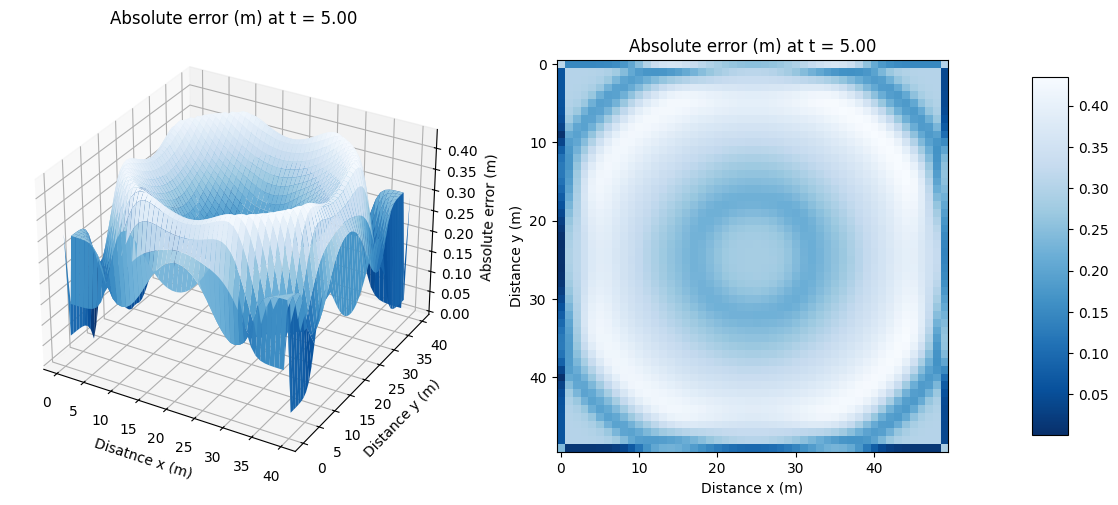

In [46]:
idx = -1
t = t_all[idx]
filename = 'plots/2D_CNN_error.pdf'
plot_error_2D(x, y, idx, t_all, pred_all, u, save_plots, filename)

# FNO

In [47]:
# Construct the file path 
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO/toro2D_N={Nx}_t={tend}.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        print(key)
    
    Q_all = f['Q_all'][:]
    t_all = f['t_all'][:]
    x = f['x'][:]
    y = f['y'][:]

print(f'Loaded Q_all with shape {Q_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded x with shape {x.shape}')
print(f'Loaded y with shape {y.shape}')

h_all = Q_all[:, 0, :, :]

Q_all
t_all
x
y
Loaded Q_all with shape (63, 3, 50, 50)
Loaded t_all with shape (63,)
Loaded x with shape (50,)
Loaded y with shape (50,)


In [48]:
if 0:   
    model = SFNO(n_modes=(16, 16),
                in_channels=1,
                out_channels=1,
                hidden_channels=16,
                projection_channel_ratio=2,
                factorization='cp',)

    n_params = count_model_params(model)
    print(f"Number of parameters: {n_params}")

if 1:
    model = TFNO(
        n_modes=(16,16), 
        in_channels=1,
        lifting_channels=32, 
        hidden_channels=32, 
        projection_channels=32, 
        out_channels=1, 
        non_linearity = torch.nn.functional.relu)

    n_params = count_model_params(model)
    print(f'\nThe model has {n_params} parameters.')


The model has 1205161 parameters.


In [49]:
## Split the data into training and testing
p_train = 0.6
p_val = 0.2
p_test = 1 - p_train - p_val
n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_2D_FNO(h_all, p_train, p_val)

batch_size = 10

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
dataloader_val = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

learn_rate = 1e-3
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=1e-4)

n_train = 37, n_val = 12, n_test = 14
torch.Size([37, 1, 50, 50]) torch.Size([37, 1, 50, 50]) torch.Size([12, 1, 50, 50]) torch.Size([12, 1, 50, 50]) torch.Size([13, 1, 50, 50]) torch.Size([13, 1, 50, 50])


In [50]:
loss_train = []
loss_val = []

model.to(device)

# Time training
start = time.time()

# Training loop
n_epochs = n_epochs_FNO
for epoch in range(n_epochs):
    model.train() # Set model to training mode
    epoch_train_loss = 0

    for batch_X, batch_y in dataloader_train:
        # To device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0) # Accumulate loss

    # Validation loss
    model.eval() # Set model to evaluation mode
    epoch_val_loss = 0
    
    with torch.no_grad(): # Disable gradient tracking
        for batch_X_val, batch_y_val in dataloader_val:
            # To device
            batch_X_val = batch_X_val.to(device)
            batch_y_val = batch_y_val.to(device)
            
            # Predictions
            val_predictions = model(batch_X_val)
            val_loss = loss_fn(val_predictions, batch_y_val)
            epoch_val_loss += val_loss.item() * batch_X_val.size(0)
    
    # Average loss
    epoch_train_loss /= len(dataloader_train.dataset)
    epoch_val_loss /= len(dataloader_val.dataset)

    # Save losses
    loss_train.append(epoch_train_loss)
    loss_val.append(epoch_val_loss)

    # Print losses
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}: Train loss = {epoch_train_loss:.6f}, Val loss = {epoch_val_loss:.6f}")

# Time training
end = time.time()
training_time = end - start
print(f"Training time: {training_time:.2f}s")

Epoch 0/10: Train loss = 1.008310, Val loss = 0.874732
Training time: 5.57s


In [51]:
# Save the training time and n_epochs
if save_results:
    file_path = os.path.join(folder_path, f'2D_FNO_Nx={Nx}_time.txt')
    with open(file_path, 'w') as f:
        f.write(f"{training_time:.2f}") # Save with 2 decimals
    
    # Save n_epochs
    file_path = os.path.join(folder_path, f'2D_FNO_Nx={Nx}_nepochs.txt')
    with open(file_path, 'w') as f:
        f.write(f"{n_epochs_FNO}") 

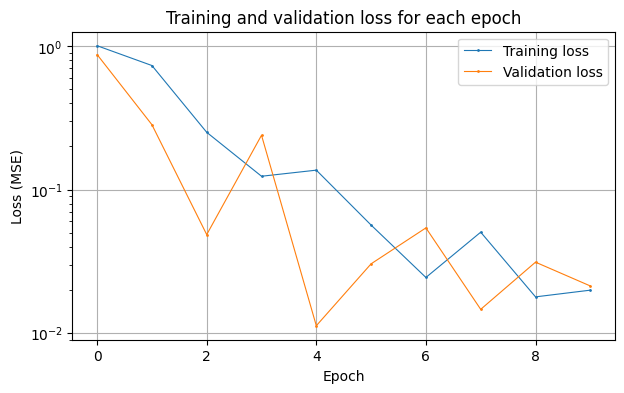

In [52]:
filename = 'plots/2D_FNO_loss.pdf'
plot_losses(loss_train, loss_val, save_plots, filename)

### Make predictions

In [53]:
pred_train = model(train_x).cpu().detach().numpy()
pred_val = model(val_x).cpu().detach().numpy()
pred_test = model(test_x).cpu().detach().numpy()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train, pred_val, pred_test], axis=0)
print(pred_all.shape)

# Compute loss
test_loss = loss_fn(torch.tensor(pred_all[:, 0, :]), torch.tensor(u[:, 0, :])).item()
print(f"Loss: {test_loss:.2e}")

# Save the test loss MSE
if save_results:
    file_path = os.path.join(folder_path, f'2D_FNO_Nx={Nx}_MSE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

# Calculate MAE
loss_new = nn.L1Loss()

train_loss = loss_new(torch.tensor(pred_train), train_y).item()
val_loss = loss_new(torch.tensor(pred_val), val_y).item()
test_loss = loss_new(torch.tensor(pred_test), test_y).item()

print(f"Train loss: {train_loss:.2e}")
print(f"Validation loss: {val_loss:.2e}")
print(f"Test loss: {test_loss:.2e}")

# Save the test loss MAE
if save_results:
    file_path = os.path.join(folder_path, f'2D_FNO_Nx={Nx}_MAE_test.txt')
    with open(file_path, 'w') as f:
        f.write(f"{test_loss:.2e}") # Save with 2 decimals

(62, 1, 50, 50)
Loss: 2.72e-02
Train loss: 1.31e-01
Validation loss: 1.36e-01
Test loss: 1.31e-01


### Plot predictions

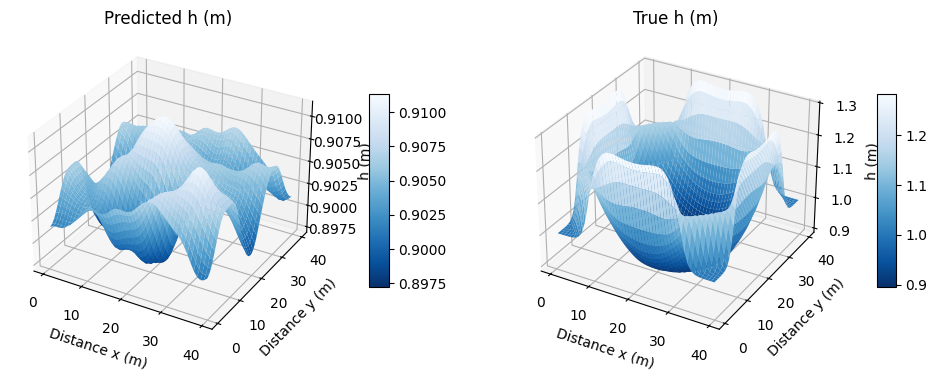

In [54]:
X, Y = np.meshgrid(x, y)
idx = -1

fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, pred_all[idx, 0, :, :], cmap = cmap)
ax.set_title('Predicted h (m)')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
ax.set_zlabel('h (m)')

plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax1 = fig.add_subplot(122, projection='3d')
surf1 = ax1.plot_surface(X, Y, h_all[idx], cmap = cmap)
ax1.set_title('True h (m)')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Distance y (m)')
ax1.set_zlabel('h (m)')
plt.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10, pad=0.1)

plt.show()


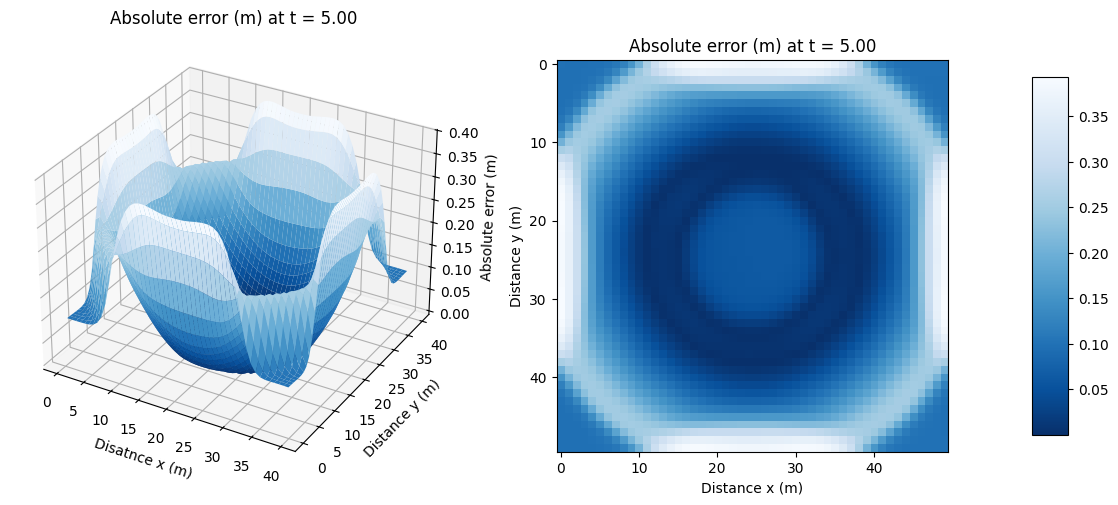

In [55]:
idx = -1
filename = 'plots/2D_FNO_error.pdf'
t = t_all[idx]
plot_error_2D(x, y, idx, t_all, pred_all.squeeze(), u.squeeze(), save_plots, filename)